<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 30%</h3>

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [5]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [6]:
noise_ratio = 0.3
loss_function = 'DampedRCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedRCELoss_aircrafts_asym_0.3_0.25_baseline
Model Features: DampedRCELoss_aircrafts_asym_0.3_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedRCELoss_aircrafts_asym_0.3_0.25
Csv save: DampedRCELoss_aircrafts_asym_0.3_0.25
Saving features from Scheme delta = 0.25: DampedRCELoss_aircrafts_asym_0.3_0.5
Saving csv for damp_2: DampedRCELoss_aircrafts_asym_0.3_0.5


# Declaration of Efficient Net family with Resolution, and Batch size 

In [3]:
architecture = 'efficientnet-b4'

effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

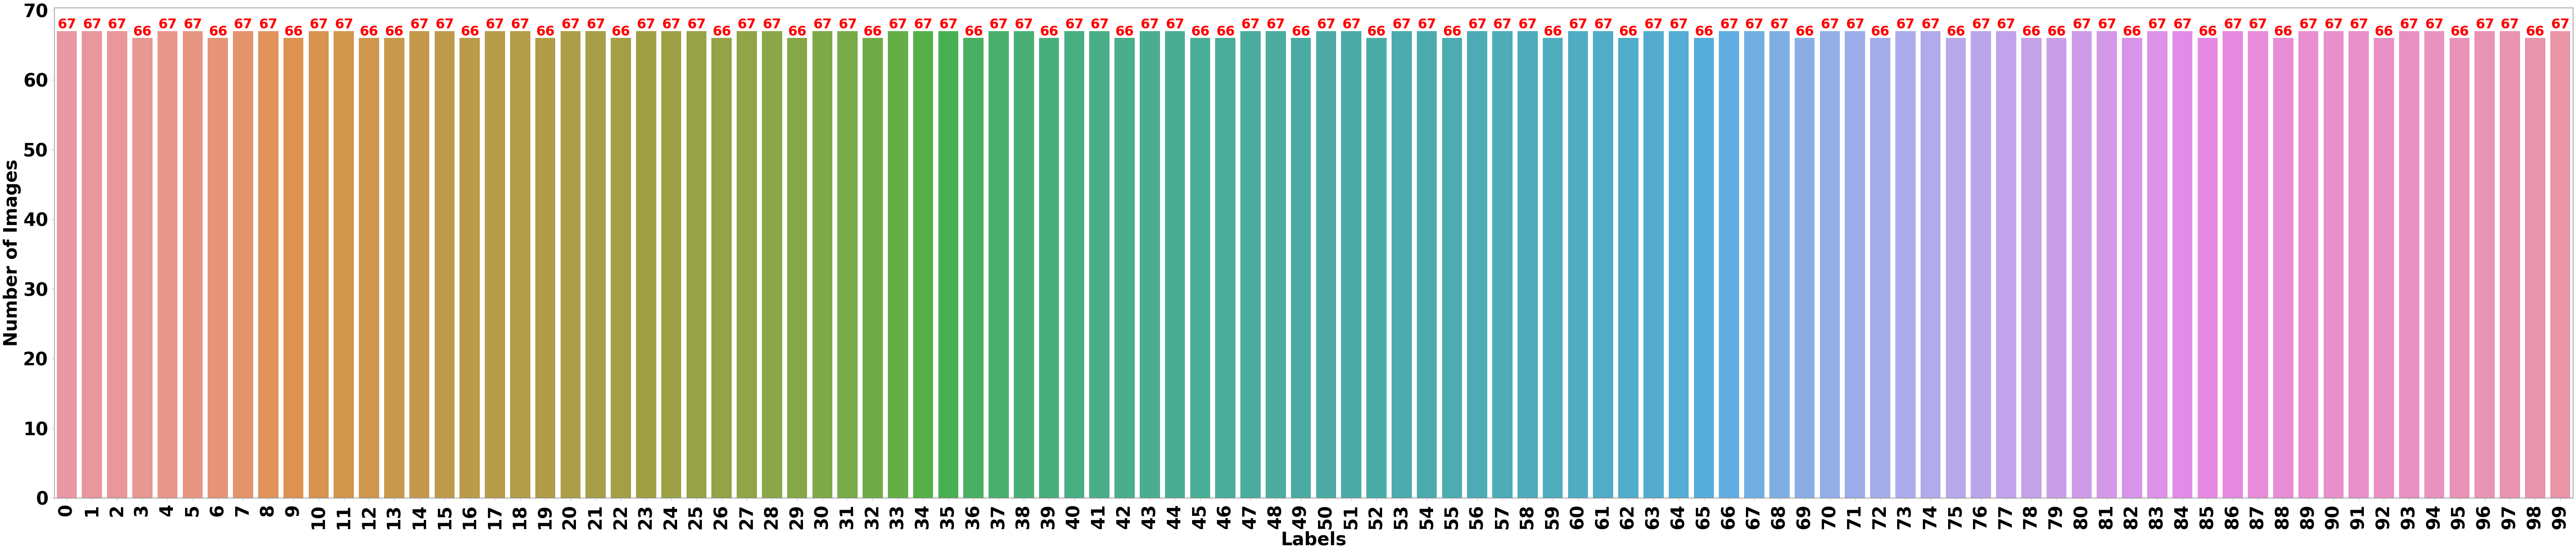

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [7]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [9]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [10]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

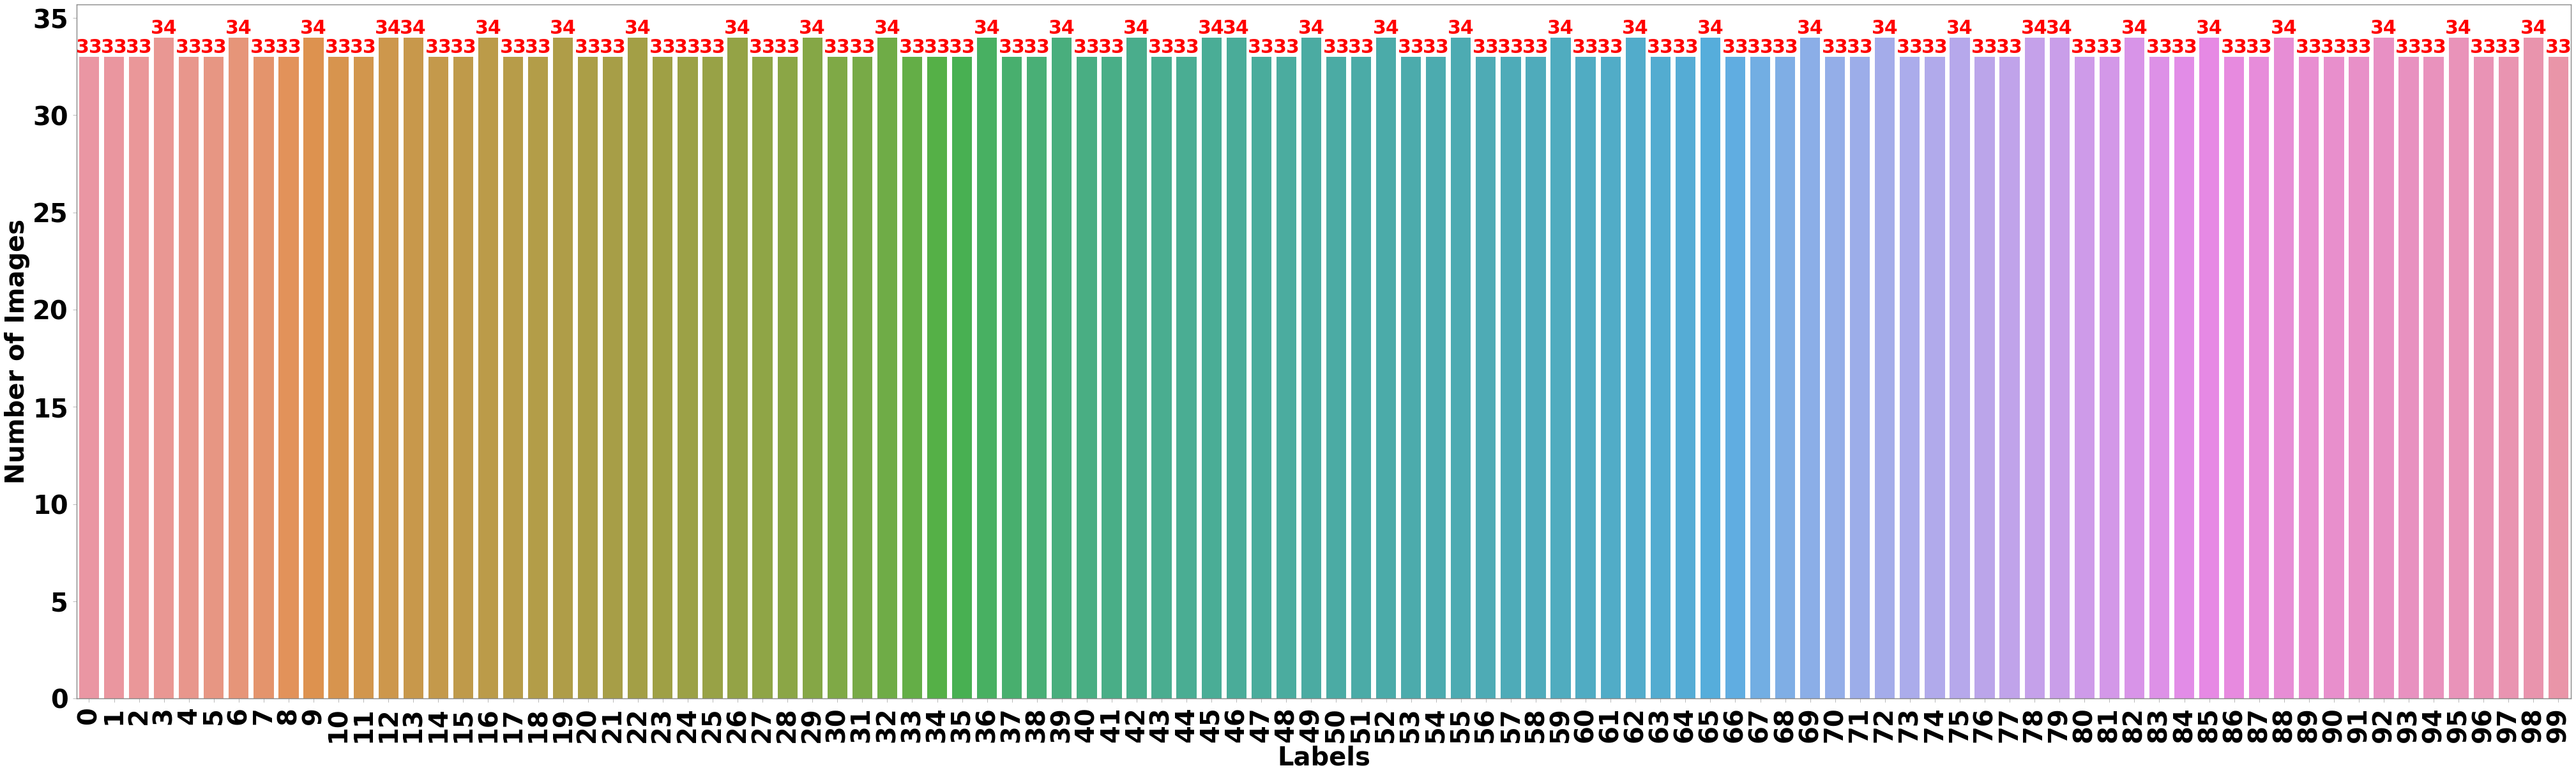

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


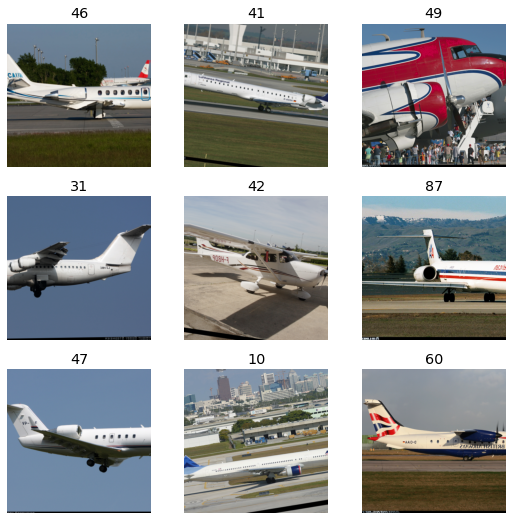

In [23]:
data0.show_batch()

In [24]:
import damped_losses as losses
loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = 0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= rce_aircrafts_asym_0.3_baseline


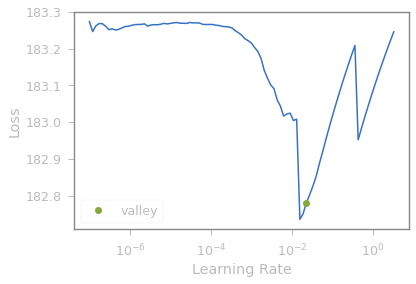

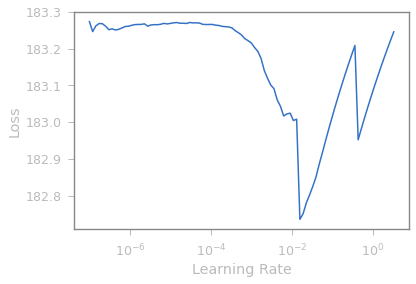

In [26]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,177.748322,172.804993,0.066017,01:49
1,176.930466,179.703705,0.030008,01:48
2,179.412323,181.990112,0.012003,01:48
3,178.335541,179.239670,0.027007,01:48
4,181.405609,181.824554,0.012753,01:48
5,181.219147,181.618469,0.013503,01:48
6,180.504089,180.938385,0.017254,01:48
7,179.342255,nan,0.022506,01:48
8,178.569122,179.105057,0.027757,01:48
9,178.237854,179.281693,0.027007,01:48


Better model found at epoch 0 with accuracy value: 0.06601650267839432.


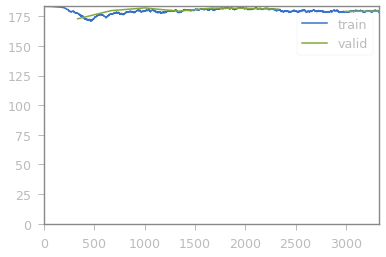

In [27]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,167.795547,168.438232,0.102776,01:48
1,161.378113,160.647232,0.146287,01:48
2,153.056961,153.064957,0.180795,01:48
3,140.611908,142.250473,0.231058,01:48
4,134.874435,140.264877,0.246062,01:48
5,128.566269,136.686005,0.268567,01:48
6,129.556915,144.259628,0.219055,01:48
7,133.451111,140.626556,0.245311,01:48
8,135.458435,143.045242,0.226557,01:48
9,130.825851,130.913727,0.301575,01:48


Better model found at epoch 0 with accuracy value: 0.1027756929397583.


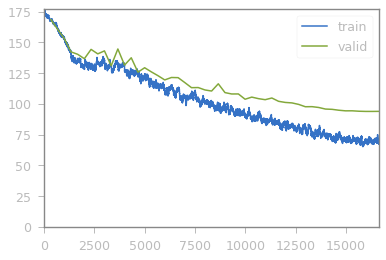

Better model found at epoch 1 with accuracy value: 0.14628657698631287.
Better model found at epoch 2 with accuracy value: 0.18079519271850586.
Better model found at epoch 3 with accuracy value: 0.2310577630996704.
Better model found at epoch 4 with accuracy value: 0.2460615187883377.
Better model found at epoch 5 with accuracy value: 0.26856714487075806.
Better model found at epoch 9 with accuracy value: 0.3015753924846649.
Better model found at epoch 13 with accuracy value: 0.3218304514884949.
Better model found at epoch 16 with accuracy value: 0.33533382415771484.
Better model found at epoch 17 with accuracy value: 0.35408851504325867.
Better model found at epoch 20 with accuracy value: 0.36534133553504944.
Better model found at epoch 21 with accuracy value: 0.38859716057777405.
Better model found at epoch 22 with accuracy value: 0.3915978968143463.
Better model found at epoch 23 with accuracy value: 0.3960990309715271.
Better model found at epoch 24 with accuracy value: 0.406601637

In [29]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [30]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.6502)


 ------------
 B0|Epochs|20|8056   |
 -----------------------------

In [31]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.6568)


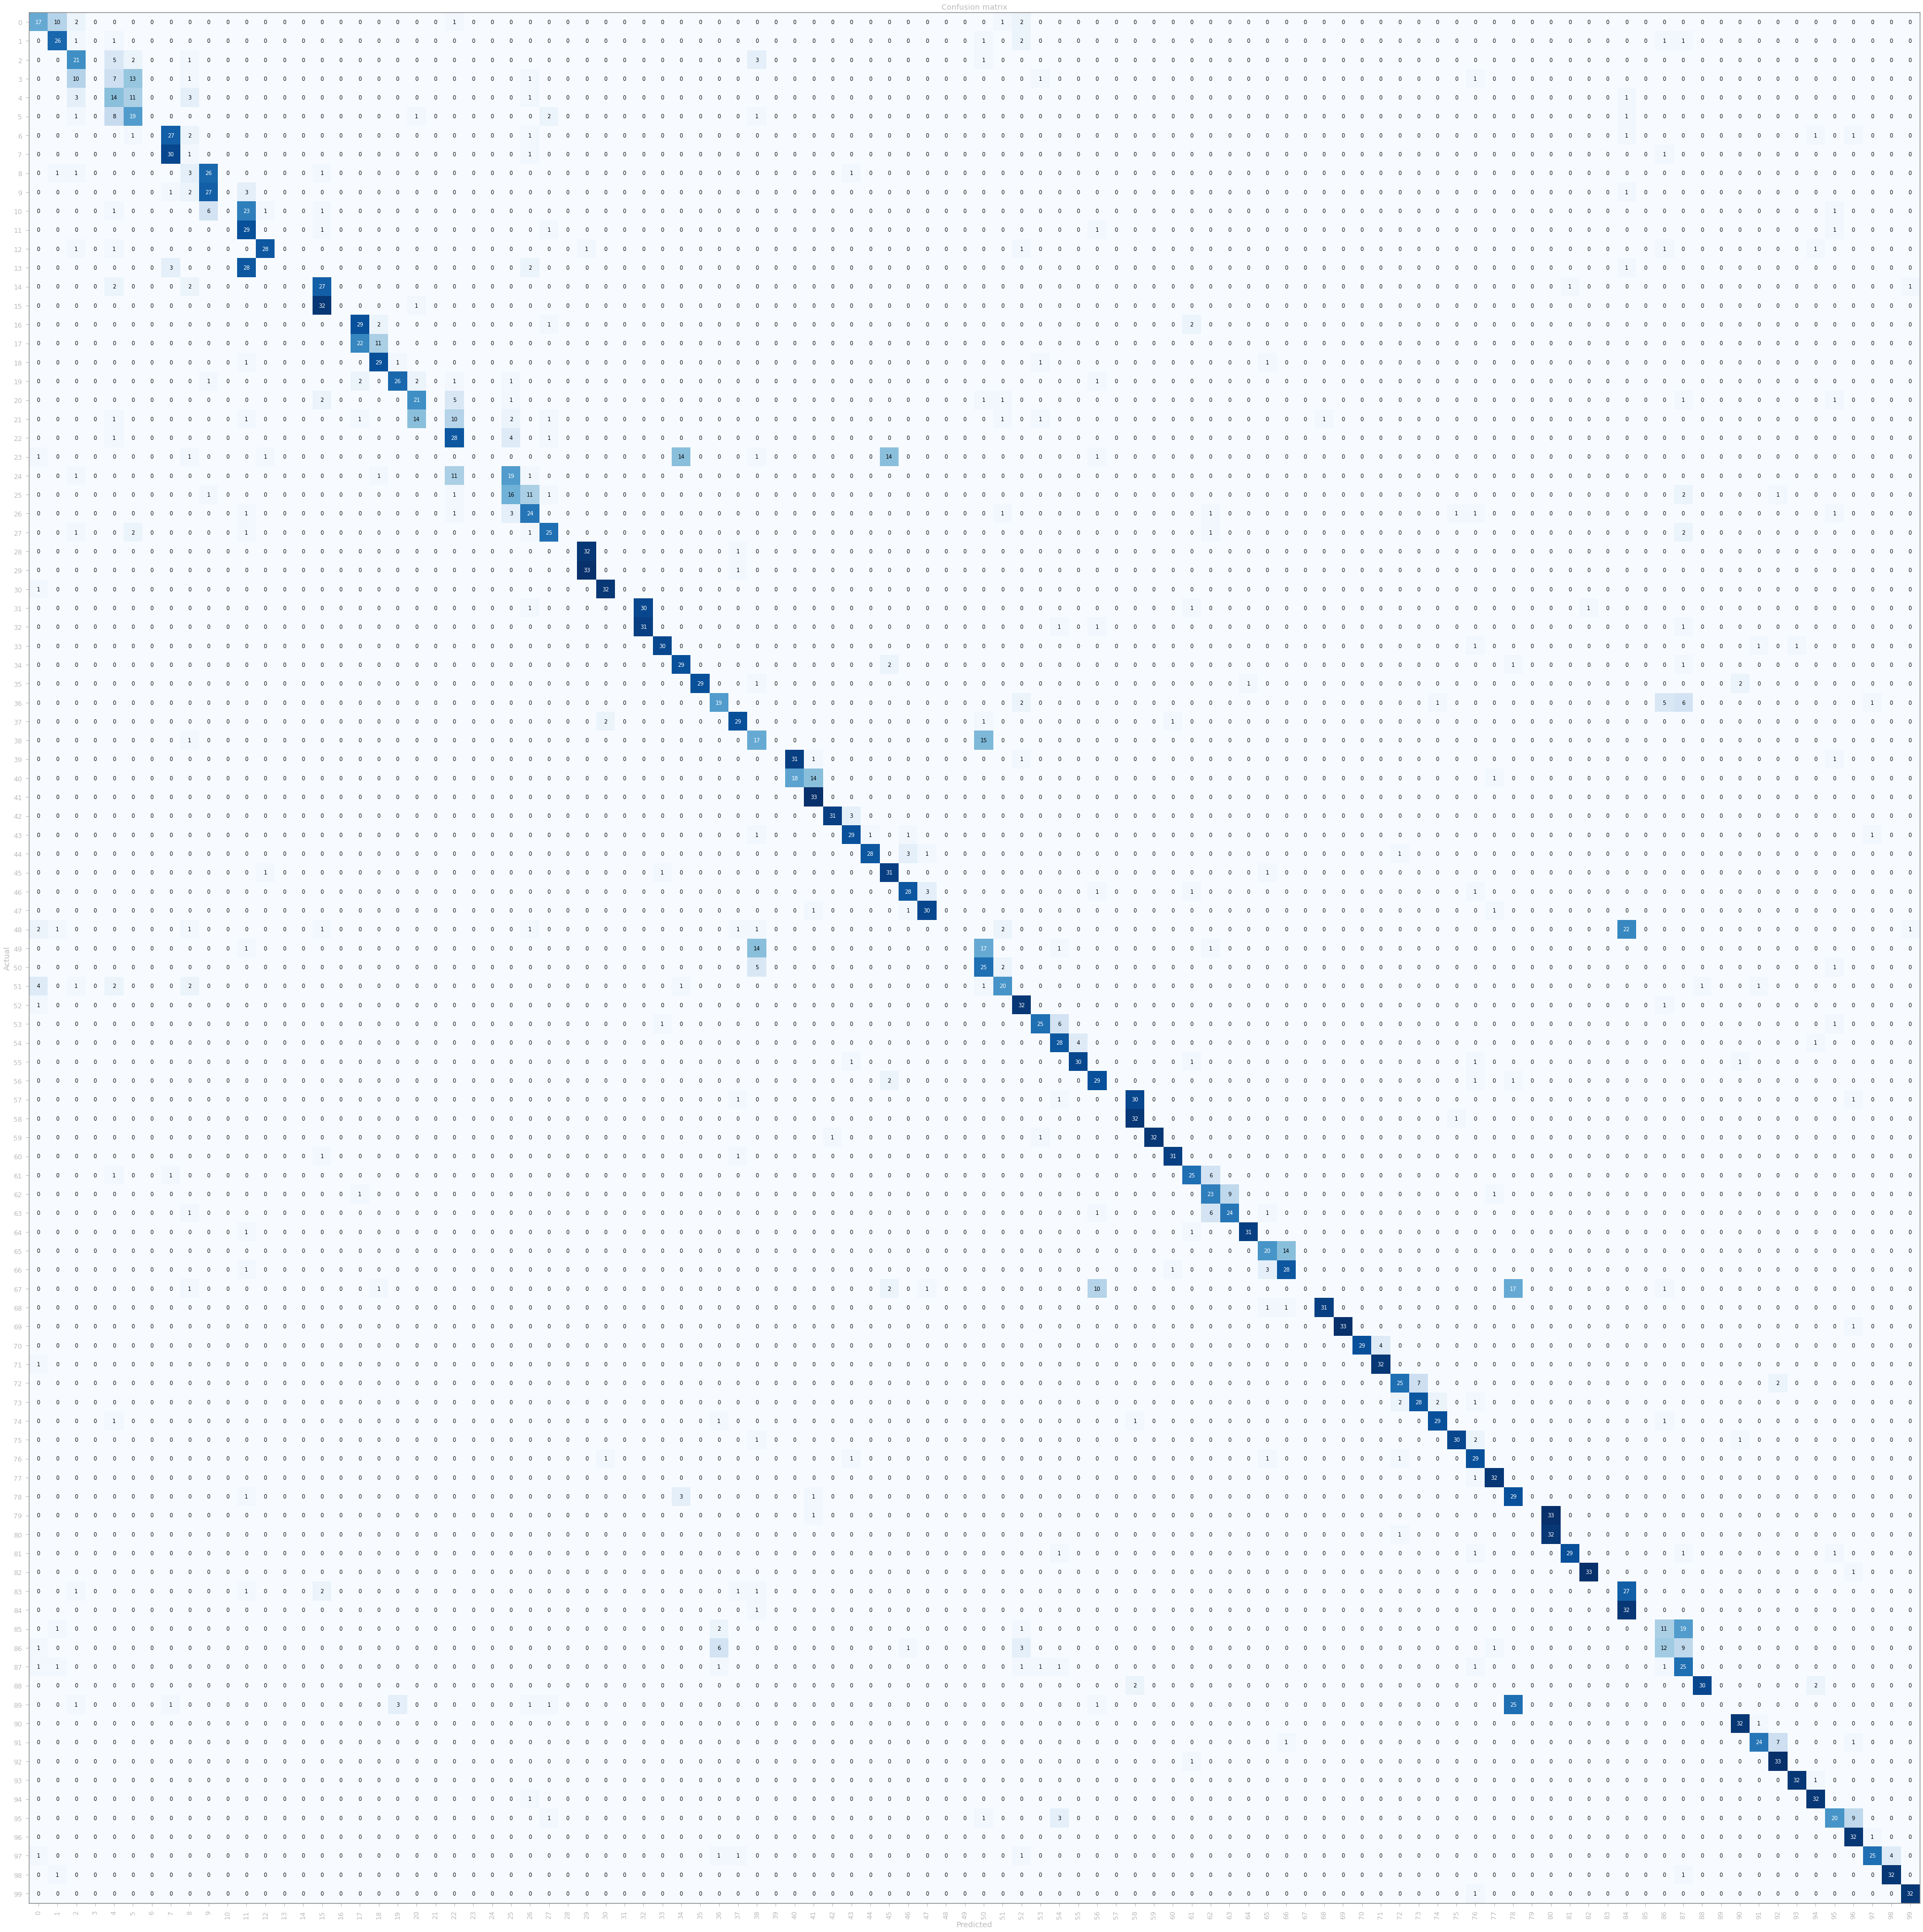

In [32]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [33]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [34]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/rce_aircrafts_asym_0.3_baseline.pth'

In [35]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 94 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6573


epoch,train_loss,valid_loss,accuracy,time
0,74.019363,75.175819,0.592846,01:48


Better model found at epoch 0 with accuracy value: 0.5928462743759155.


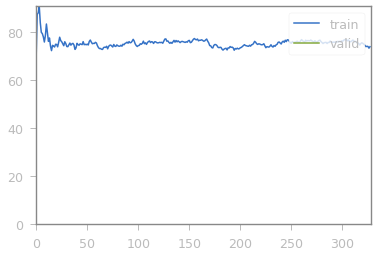

************Round:  0
TTA Accuracy:0.650765061378479
cycle 0 Error Rate is [{0: (1.4099295035248205, 34.9234938621521)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 80 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6493


epoch,train_loss,valid_loss,accuracy,time
0,77.739059,72.205162,0.610169,01:46


Better model found at epoch 0 with accuracy value: 0.6101694703102112.


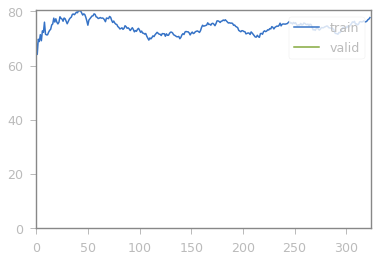

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 59 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6434


epoch,train_loss,valid_loss,accuracy,time
0,72.864136,72.379578,0.611198,01:46


Better model found at epoch 0 with accuracy value: 0.6111975312232971.


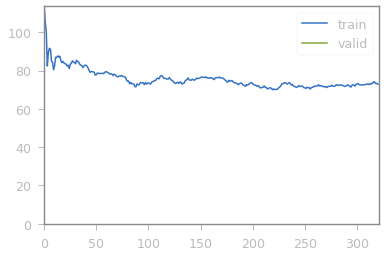

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 71 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6363


epoch,train_loss,valid_loss,accuracy,time
0,75.032074,67.518715,0.635220,01:46


Better model found at epoch 0 with accuracy value: 0.6352201104164124.


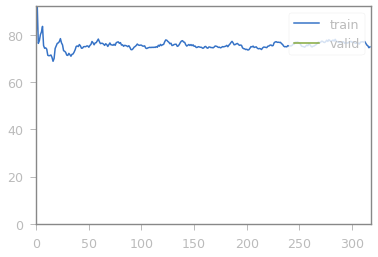

************Round:  3
TTA Accuracy:0.6567656993865967
cycle 0 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 64 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6299


epoch,train_loss,valid_loss,accuracy,time
0,71.760307,71.731560,0.612391,01:43


Better model found at epoch 0 with accuracy value: 0.6123907566070557.


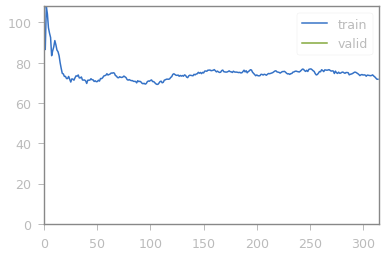

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 62 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6237


epoch,train_loss,valid_loss,accuracy,time
0,76.266304,72.032387,0.608661,01:44


Better model found at epoch 0 with accuracy value: 0.6086607575416565.


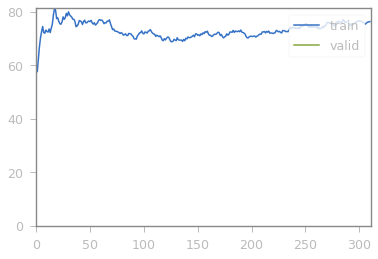

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 53 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6184


epoch,train_loss,valid_loss,accuracy,time
0,77.625870,69.128250,0.626214,01:42


Better model found at epoch 0 with accuracy value: 0.6262136101722717.


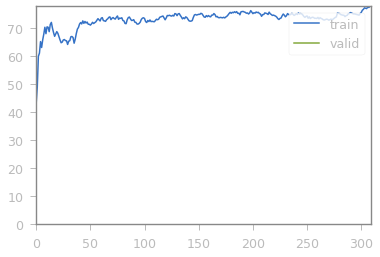

************Round:  6
TTA Accuracy:0.6582658290863037
cycle 0 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 42 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6142


epoch,train_loss,valid_loss,accuracy,time
0,72.329132,68.802856,0.629479,01:42


Better model found at epoch 0 with accuracy value: 0.6294788122177124.


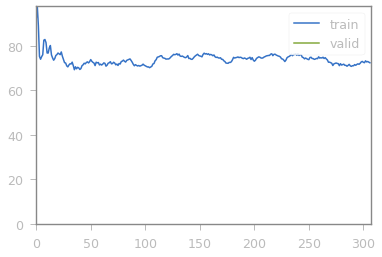

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 53 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6089


epoch,train_loss,valid_loss,accuracy,time
0,73.132988,72.474907,0.611339,01:41


Better model found at epoch 0 with accuracy value: 0.6113393306732178.


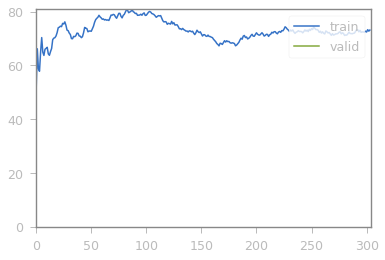

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 53 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6036


epoch,train_loss,valid_loss,accuracy,time
0,75.640564,71.575417,0.613919,01:40


Better model found at epoch 0 with accuracy value: 0.6139187812805176.


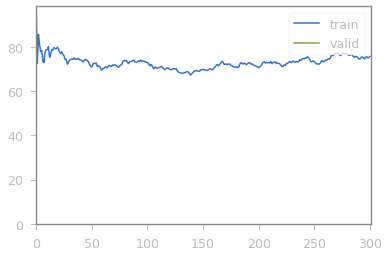

************Round:  9
TTA Accuracy:0.6603660583496094
cycle 0 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 56 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5980


epoch,train_loss,valid_loss,accuracy,time
0,78.113602,66.841026,0.641304,01:37


Better model found at epoch 0 with accuracy value: 0.6413043737411499.


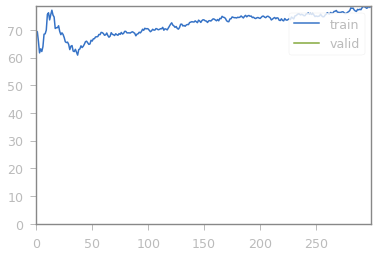

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 42 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5938


epoch,train_loss,valid_loss,accuracy,time
0,71.107864,67.123497,0.636900,01:38


Better model found at epoch 0 with accuracy value: 0.6368997693061829.


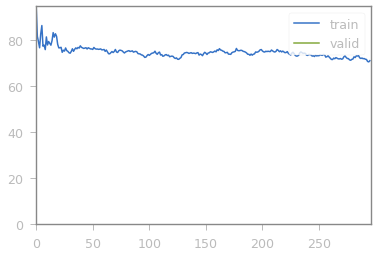

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 42 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5896


epoch,train_loss,valid_loss,accuracy,time
0,72.072563,69.072411,0.628499,01:36


Better model found at epoch 0 with accuracy value: 0.6284987330436707.


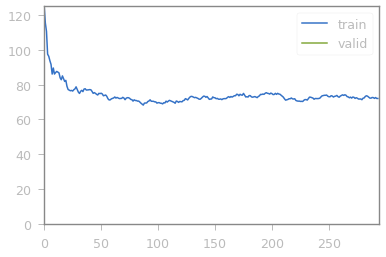

************Round:  12
TTA Accuracy:0.6606660485267639
cycle 0 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 47 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5849


epoch,train_loss,valid_loss,accuracy,time
0,72.257568,68.185188,0.631309,01:36


Better model found at epoch 0 with accuracy value: 0.6313087940216064.


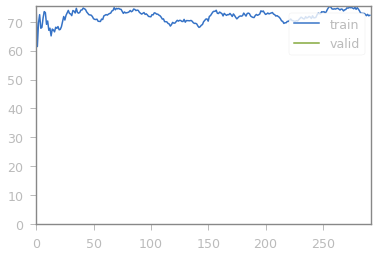

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 34
Min probability = 0.4567164179104478
Dropped 48 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5801


epoch,train_loss,valid_loss,accuracy,time
0,71.563293,70.113495,0.619828,01:35


Better model found at epoch 0 with accuracy value: 0.6198275685310364.


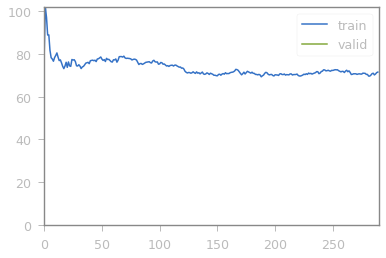

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,74.822929,67.795792,0.632700,01:47


Better model found at epoch 0 with accuracy value: 0.6326996088027954.


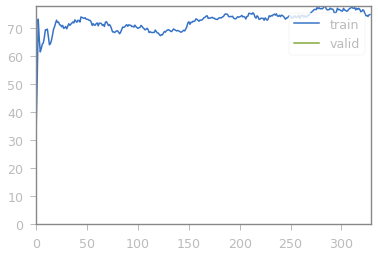

************Round:  0
TTA Accuracy:0.6588658690452576
cycle 1 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 77 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6502


epoch,train_loss,valid_loss,accuracy,time
0,73.531059,66.149673,0.642308,01:46


Better model found at epoch 0 with accuracy value: 0.642307698726654.


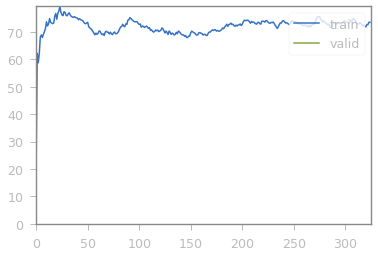

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 79 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6423


epoch,train_loss,valid_loss,accuracy,time
0,68.784218,68.053139,0.632399,01:45


Better model found at epoch 0 with accuracy value: 0.6323987245559692.


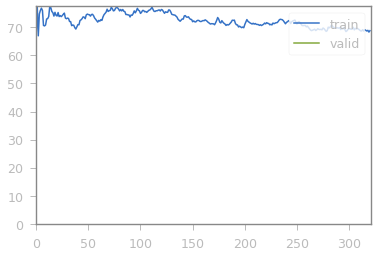

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 59 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6364


epoch,train_loss,valid_loss,accuracy,time
0,69.391907,71.956993,0.612421,01:44


Better model found at epoch 0 with accuracy value: 0.6124213933944702.


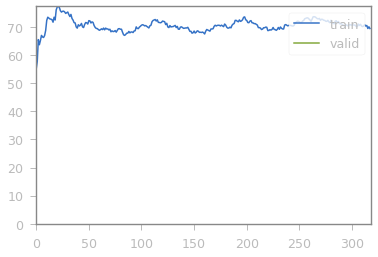

************Round:  3
TTA Accuracy:0.6552655100822449
cycle 1 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 71 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6293


epoch,train_loss,valid_loss,accuracy,time
0,71.299782,67.181908,0.636725,01:44


Better model found at epoch 0 with accuracy value: 0.6367249488830566.


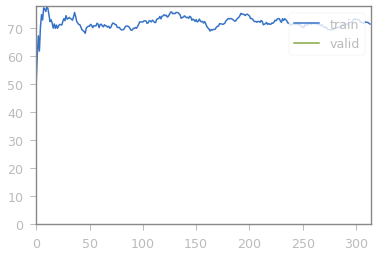

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 59 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6234


epoch,train_loss,valid_loss,accuracy,time
0,68.707603,69.615562,0.622793,01:44


Better model found at epoch 0 with accuracy value: 0.6227929592132568.


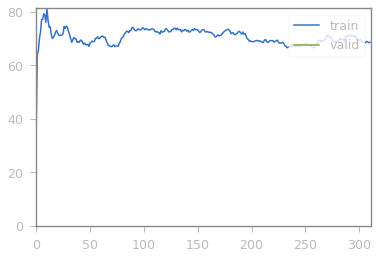

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 48 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6186


epoch,train_loss,valid_loss,accuracy,time
0,69.410553,69.668808,0.619240,01:41


Better model found at epoch 0 with accuracy value: 0.6192401051521301.


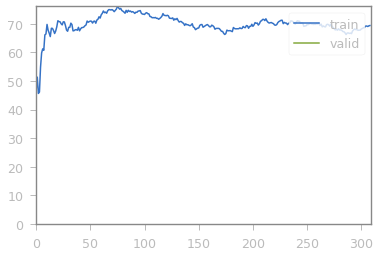

************Round:  6
TTA Accuracy:0.6558656096458435
cycle 1 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 46 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6140


epoch,train_loss,valid_loss,accuracy,time
0,73.122498,67.923805,0.631922,01:40


Better model found at epoch 0 with accuracy value: 0.6319218277931213.


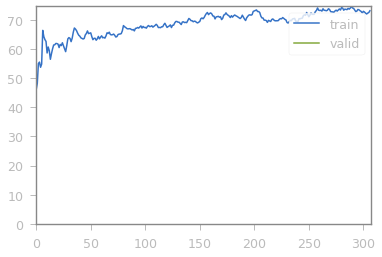

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 54 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6086


epoch,train_loss,valid_loss,accuracy,time
0,68.753189,67.632263,0.634347,01:40


Better model found at epoch 0 with accuracy value: 0.6343467831611633.


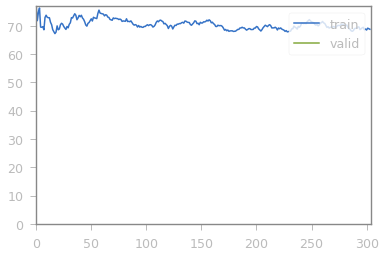

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 49 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6037


epoch,train_loss,valid_loss,accuracy,time
0,71.200508,66.206497,0.641259,01:38


Better model found at epoch 0 with accuracy value: 0.6412593126296997.


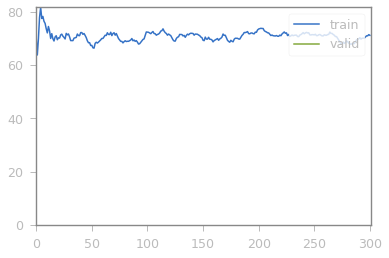

************Round:  9
TTA Accuracy:0.6582658290863037
cycle 1 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 36
Min probability = 0.4835820895522388
Dropped 45 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5992


epoch,train_loss,valid_loss,accuracy,time
0,69.829849,64.907173,0.650250,01:38


Better model found at epoch 0 with accuracy value: 0.6502504348754883.


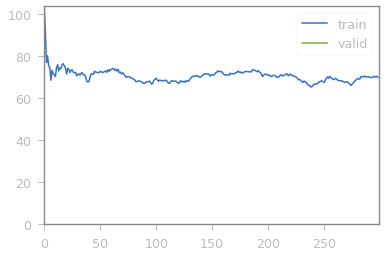

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 35 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5957


epoch,train_loss,valid_loss,accuracy,time
0,65.349152,65.996391,0.645676,01:37


Better model found at epoch 0 with accuracy value: 0.6456758975982666.


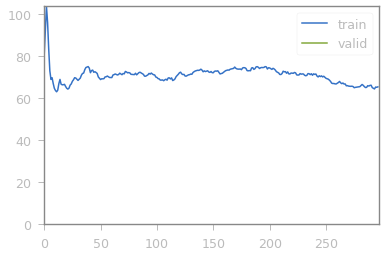

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 42 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5915


epoch,train_loss,valid_loss,accuracy,time
0,71.492592,67.226006,0.636517,01:36


Better model found at epoch 0 with accuracy value: 0.636517345905304.


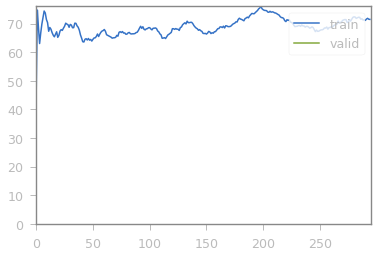

************Round:  12
TTA Accuracy:0.6591659188270569
cycle 1 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 45 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5870


epoch,train_loss,valid_loss,accuracy,time
0,73.282768,62.767929,0.662692,01:36


Better model found at epoch 0 with accuracy value: 0.6626916527748108.


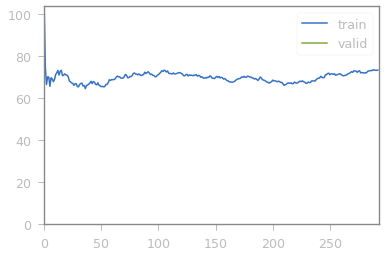

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 35
Min probability = 0.47014925373134325
Dropped 58 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5812


epoch,train_loss,valid_loss,accuracy,time
0,68.714134,68.870102,0.626506,01:35


Better model found at epoch 0 with accuracy value: 0.6265060305595398.


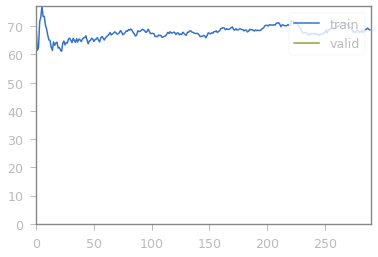

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 89 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6578


epoch,train_loss,valid_loss,accuracy,time
0,70.576057,68.394913,0.628897,01:47


Better model found at epoch 0 with accuracy value: 0.6288973093032837.


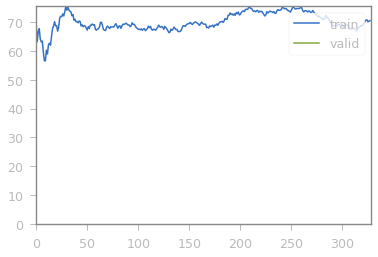

************Round:  0
TTA Accuracy:0.6663666367530823
cycle 2 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431), 30: (1.3349332533373337, 33.36333632469177)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 75 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6503


epoch,train_loss,valid_loss,accuracy,time
0,70.558144,68.846413,0.628462,01:46


Better model found at epoch 0 with accuracy value: 0.6284615397453308.


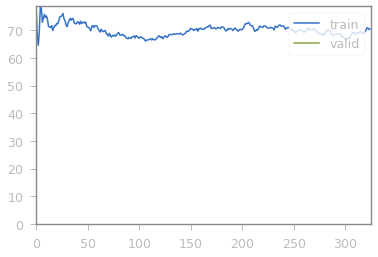

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 69 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6434


epoch,train_loss,valid_loss,accuracy,time
0,66.590950,68.147781,0.631415,01:45


Better model found at epoch 0 with accuracy value: 0.6314152479171753.


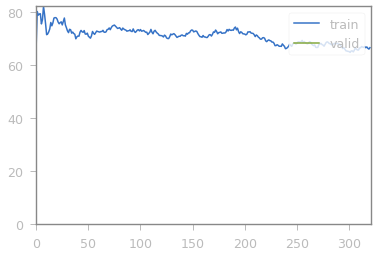

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 70 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6364


epoch,train_loss,valid_loss,accuracy,time
0,71.702477,68.363190,0.631289,01:44


Better model found at epoch 0 with accuracy value: 0.6312893033027649.


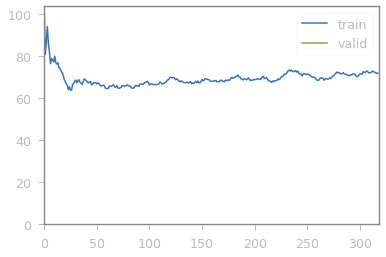

************Round:  3
TTA Accuracy:0.6645664572715759
cycle 2 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431), 30: (1.3349332533373337, 33.36333632469177), 33: (4.544772761361937, 33.54335427284241)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 60 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6304


epoch,train_loss,valid_loss,accuracy,time
0,68.708282,62.628700,0.661111,01:42


Better model found at epoch 0 with accuracy value: 0.6611111164093018.


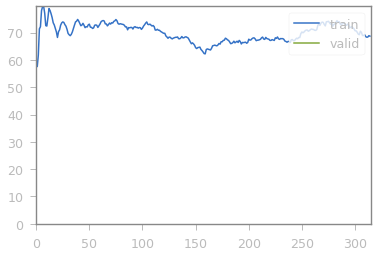

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 52 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6252


epoch,train_loss,valid_loss,accuracy,time
0,68.227463,62.211319,0.664000,01:42


Better model found at epoch 0 with accuracy value: 0.6639999747276306.


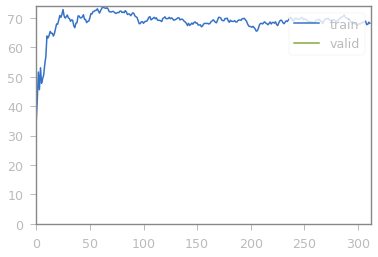

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 62 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6190


epoch,train_loss,valid_loss,accuracy,time
0,70.462212,61.643738,0.666397,01:41


Better model found at epoch 0 with accuracy value: 0.6663973927497864.


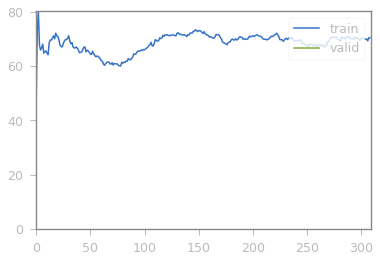

************Round:  6
TTA Accuracy:0.6690669059753418
cycle 2 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431), 30: (1.3349332533373337, 33.36333632469177), 33: (4.544772761361937, 33.54335427284241), 36: (7.154642267886602, 33.09330940246582)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 60 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6130


epoch,train_loss,valid_loss,accuracy,time
0,64.618629,68.210426,0.629690,01:40


Better model found at epoch 0 with accuracy value: 0.6296900510787964.


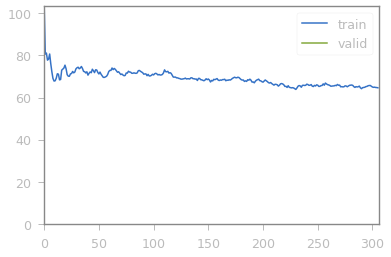

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 63 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6067


epoch,train_loss,valid_loss,accuracy,time
0,65.076027,65.206413,0.647156,01:41


Better model found at epoch 0 with accuracy value: 0.6471558213233948.


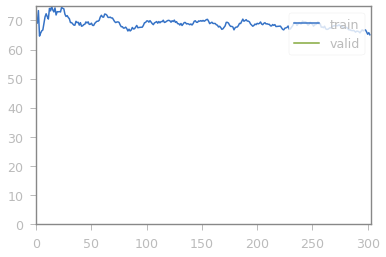

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 62 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6005


epoch,train_loss,valid_loss,accuracy,time
0,68.677597,66.516464,0.639467,01:38


Better model found at epoch 0 with accuracy value: 0.6394671201705933.


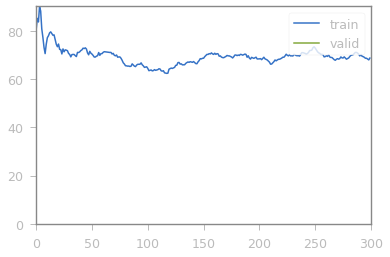

************Round:  9
TTA Accuracy:0.6687668561935425
cycle 2 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431), 30: (1.3349332533373337, 33.36333632469177), 33: (4.544772761361937, 33.54335427284241), 36: (7.154642267886602, 33.09330940246582), 39: (9.929503524823758, 33.12331438064575)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 54 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5951


epoch,train_loss,valid_loss,accuracy,time
0,70.800751,63.088715,0.657143,01:37


Better model found at epoch 0 with accuracy value: 0.6571428775787354.


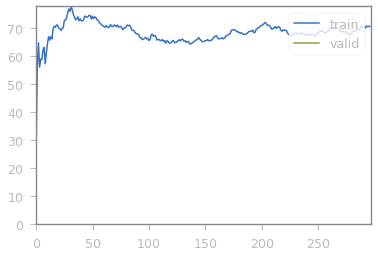

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 54 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5897


epoch,train_loss,valid_loss,accuracy,time
0,68.377701,64.407288,0.651399,01:36


Better model found at epoch 0 with accuracy value: 0.6513994932174683.


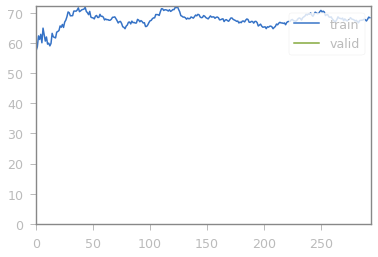

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 54 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5843


epoch,train_loss,valid_loss,accuracy,time
0,67.073700,64.916618,0.649829,01:36


Better model found at epoch 0 with accuracy value: 0.6498287916183472.


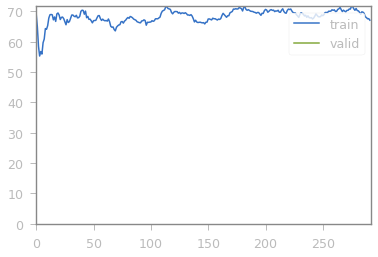

************Round:  12
TTA Accuracy:0.6675667762756348
cycle 2 Error Rate is [{0: (1.4099295035248205, 34.9234938621521), 3: (4.559772011399432, 34.32343006134033), 6: (7.244637768111595, 34.17341709136963), 9: (9.46452677366132, 33.96339416503906), 12: (11.564421778911049, 33.93339514732361), 15: (1.3199340032998386, 34.11341309547424), 18: (4.544772761361937, 34.47344899177551), 21: (7.214639268036594, 34.41343903541565), 24: (9.449527523623825, 34.17341709136963), 27: (11.279436028198585, 34.08340811729431), 30: (1.3349332533373337, 33.36333632469177), 33: (4.544772761361937, 33.54335427284241), 36: (7.154642267886602, 33.09330940246582), 39: (9.929503524823758, 33.12331438064575), 42: (12.359382030898459, 33.24332237243652)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 57 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5786


epoch,train_loss,valid_loss,accuracy,time
0,66.738045,67.757507,0.636128,01:35


Better model found at epoch 0 with accuracy value: 0.6361278891563416.


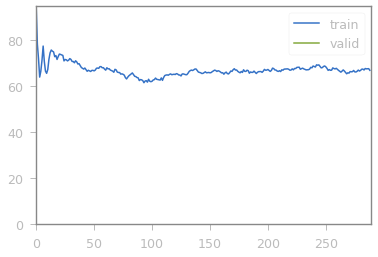

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 39
Min probability = 0.5238805970149254
Dropped 55 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5731


epoch,train_loss,valid_loss,accuracy,time
0,66.248344,63.932449,0.654450,01:34


Better model found at epoch 0 with accuracy value: 0.6544502377510071.


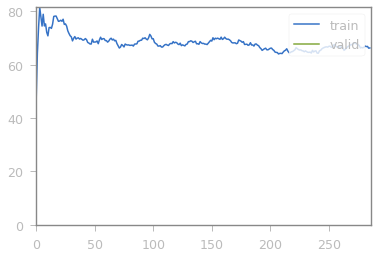

In [36]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        k_samples = 100
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)


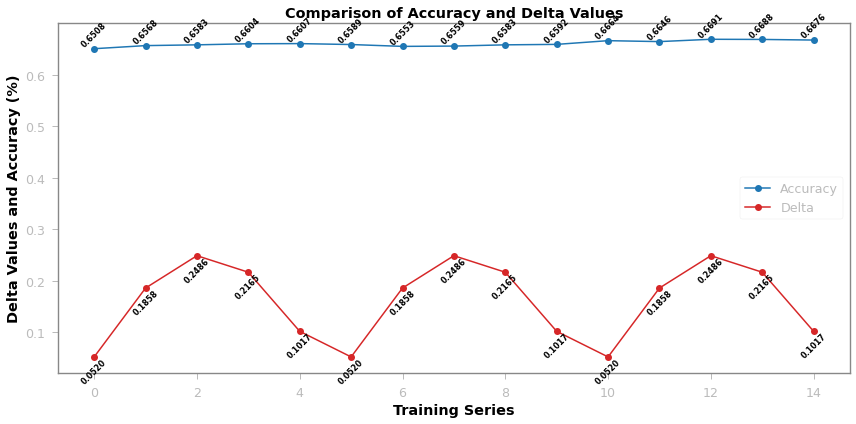

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 94 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6573


epoch,train_loss,valid_loss,accuracy,time
0,66.441948,66.816422,0.639269,01:47


Better model found at epoch 0 with accuracy value: 0.6392694115638733.


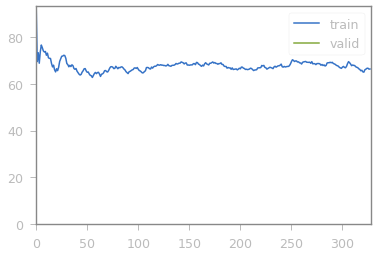

************Round:  0
TTA Accuracy:0.6705670356750488
cycle 0 Error Rate is [{0: (1.4099295035248205, 32.94329643249512)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6495


epoch,train_loss,valid_loss,accuracy,time
0,70.368576,61.938133,0.665897,01:46


Better model found at epoch 0 with accuracy value: 0.6658968329429626.


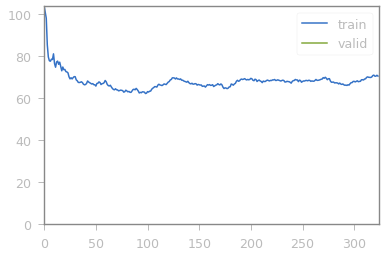

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 72 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6423


epoch,train_loss,valid_loss,accuracy,time
0,70.361198,58.427704,0.683801,01:44


Better model found at epoch 0 with accuracy value: 0.6838006377220154.


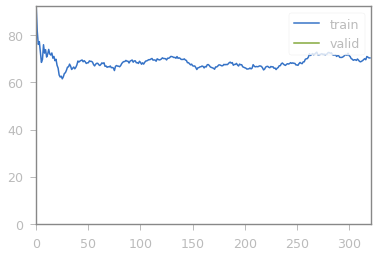

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 64 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6359


epoch,train_loss,valid_loss,accuracy,time
0,68.193436,62.595791,0.659323,01:44


Better model found at epoch 0 with accuracy value: 0.6593233942985535.


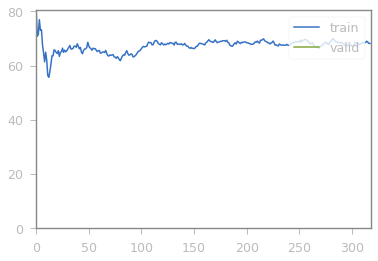

************Round:  3
TTA Accuracy:0.6633663177490234
cycle 0 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 67 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6292


epoch,train_loss,valid_loss,accuracy,time
0,69.019722,64.409737,0.650238,01:42


Better model found at epoch 0 with accuracy value: 0.6502384543418884.


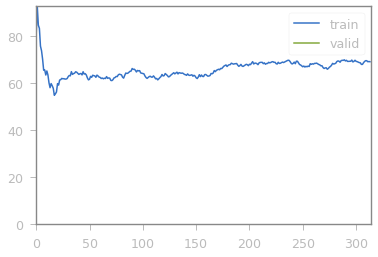

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 64 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6228


epoch,train_loss,valid_loss,accuracy,time
0,67.550415,62.141171,0.663454,01:41


Better model found at epoch 0 with accuracy value: 0.6634538173675537.


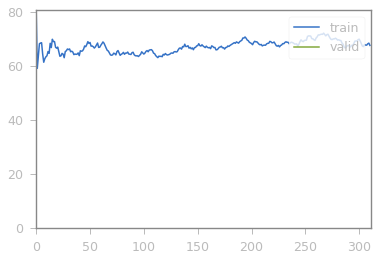

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 54 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6174


epoch,train_loss,valid_loss,accuracy,time
0,63.715157,63.869743,0.654781,01:41


Better model found at epoch 0 with accuracy value: 0.6547812223434448.


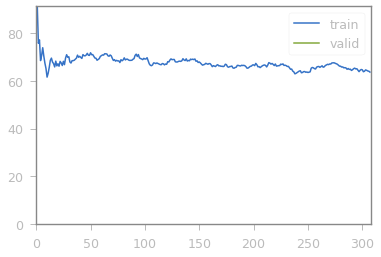

************Round:  6
TTA Accuracy:0.6675667762756348
cycle 0 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 55 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6119


epoch,train_loss,valid_loss,accuracy,time
0,63.868027,62.435997,0.661488,01:40


Better model found at epoch 0 with accuracy value: 0.6614881157875061.


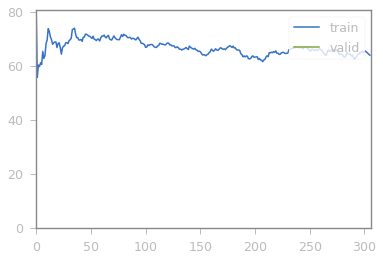

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 60 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6059


epoch,train_loss,valid_loss,accuracy,time
0,64.386086,63.542797,0.654005,01:39


Better model found at epoch 0 with accuracy value: 0.6540049314498901.


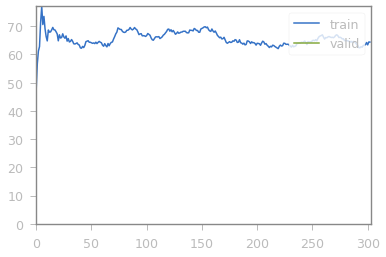

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 60 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5999


epoch,train_loss,valid_loss,accuracy,time
0,63.886333,65.590294,0.645538,01:38


Better model found at epoch 0 with accuracy value: 0.6455379724502563.


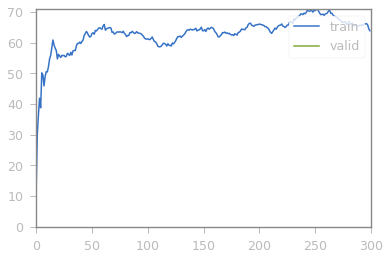

************Round:  9
TTA Accuracy:0.6669666767120361
cycle 0 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 44 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5955


epoch,train_loss,valid_loss,accuracy,time
0,64.076286,63.665340,0.655751,01:37


Better model found at epoch 0 with accuracy value: 0.6557514667510986.


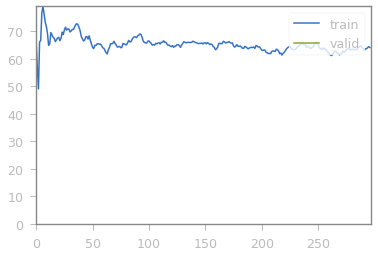

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 59 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5896


epoch,train_loss,valid_loss,accuracy,time
0,64.543335,62.870350,0.659881,01:36


Better model found at epoch 0 with accuracy value: 0.6598812341690063.


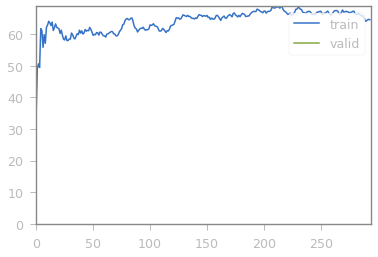

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 48 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5848


epoch,train_loss,valid_loss,accuracy,time
0,61.157494,62.017685,0.663815,01:35


Better model found at epoch 0 with accuracy value: 0.6638152003288269.


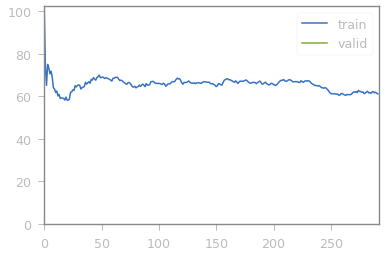

************Round:  12
TTA Accuracy:0.6648665070533752
cycle 0 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 46 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5802


epoch,train_loss,valid_loss,accuracy,time
0,64.308838,62.726696,0.661207,01:35


Better model found at epoch 0 with accuracy value: 0.6612069010734558.


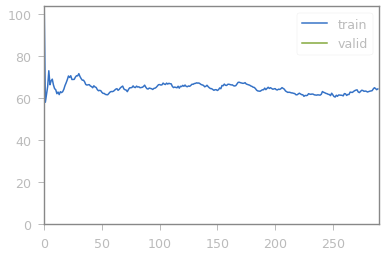

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 58 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5744


epoch,train_loss,valid_loss,accuracy,time
0,63.549088,60.472317,0.671603,01:34


Better model found at epoch 0 with accuracy value: 0.6716027855873108.


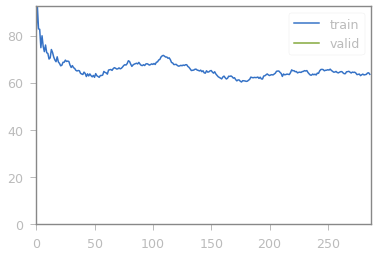

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,65.040955,66.209824,0.643346,01:47


Better model found at epoch 0 with accuracy value: 0.6433460116386414.


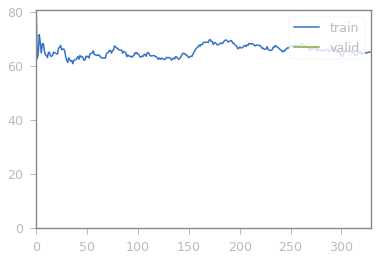

************Round:  0
TTA Accuracy:0.6720672249794006
cycle 1 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 82 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6497


epoch,train_loss,valid_loss,accuracy,time
0,68.883377,62.191525,0.662818,01:46


Better model found at epoch 0 with accuracy value: 0.6628175377845764.


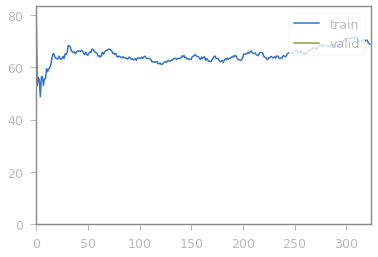

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 68 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6429


epoch,train_loss,valid_loss,accuracy,time
0,66.366173,60.049427,0.676265,01:45


Better model found at epoch 0 with accuracy value: 0.6762645840644836.


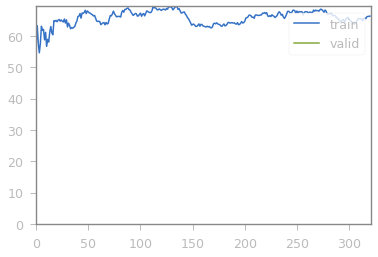

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 46
Min probability = 0.6179104477611941
Dropped 54 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6375


epoch,train_loss,valid_loss,accuracy,time
0,62.494267,63.422401,0.658039,01:44


Better model found at epoch 0 with accuracy value: 0.6580392122268677.


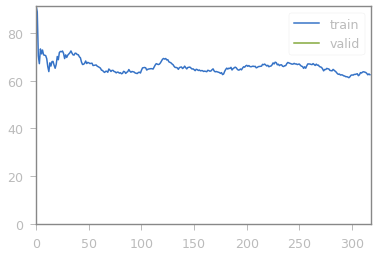

************Round:  3
TTA Accuracy:0.6684668660163879
cycle 1 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 68 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6307


epoch,train_loss,valid_loss,accuracy,time
0,61.391182,65.460556,0.646312,01:43


Better model found at epoch 0 with accuracy value: 0.6463124752044678.


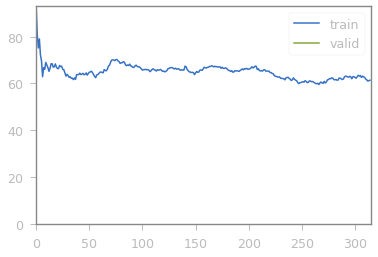

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 63 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6244


epoch,train_loss,valid_loss,accuracy,time
0,66.965927,60.051338,0.677083,01:42


Better model found at epoch 0 with accuracy value: 0.6770833134651184.


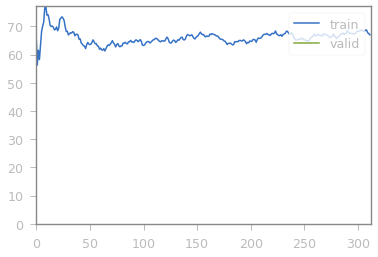

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 66 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6178


epoch,train_loss,valid_loss,accuracy,time
0,66.289322,57.296143,0.692308,01:40


Better model found at epoch 0 with accuracy value: 0.692307710647583.


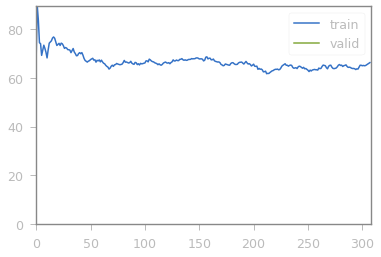

************Round:  6
TTA Accuracy:0.6711671352386475
cycle 1 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 63 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6115


epoch,train_loss,valid_loss,accuracy,time
0,66.298286,62.628994,0.660670,01:39


Better model found at epoch 0 with accuracy value: 0.6606704592704773.


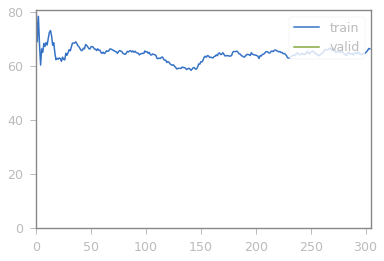

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 57 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6058


epoch,train_loss,valid_loss,accuracy,time
0,65.907166,62.225826,0.663088,01:39


Better model found at epoch 0 with accuracy value: 0.6630883812904358.


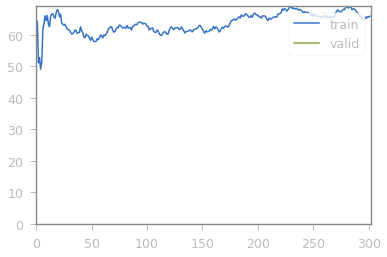

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 53 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6005


epoch,train_loss,valid_loss,accuracy,time
0,62.889053,59.602505,0.676103,01:38


Better model found at epoch 0 with accuracy value: 0.6761032342910767.


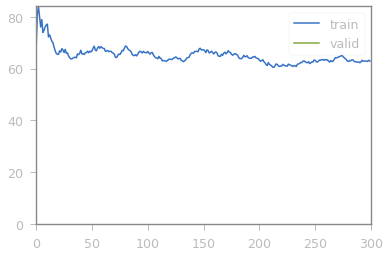

************Round:  9
TTA Accuracy:0.6720672249794006
cycle 1 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 60 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5945


epoch,train_loss,valid_loss,accuracy,time
0,65.113091,57.735138,0.687973,01:37


Better model found at epoch 0 with accuracy value: 0.6879730820655823.


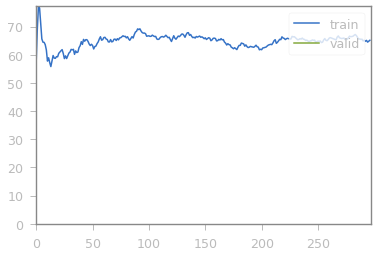

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 59 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5886


epoch,train_loss,valid_loss,accuracy,time
0,64.107117,61.163643,0.669499,01:36


Better model found at epoch 0 with accuracy value: 0.6694987416267395.


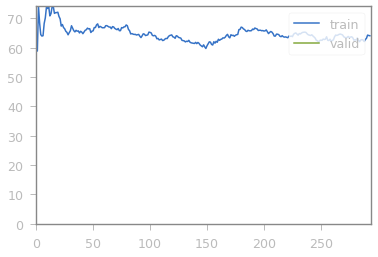

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 42
Min probability = 0.564179104477612
Dropped 51 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5835


epoch,train_loss,valid_loss,accuracy,time
0,64.585648,64.074509,0.652956,01:35


Better model found at epoch 0 with accuracy value: 0.6529563069343567.


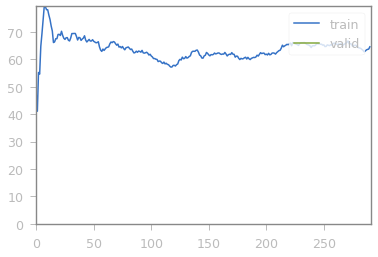

************Round:  12
TTA Accuracy:0.666066586971283
cycle 1 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 41
Min probability = 0.5507462686567164
Dropped 60 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5775


epoch,train_loss,valid_loss,accuracy,time
0,63.888840,60.153011,0.675325,01:34


Better model found at epoch 0 with accuracy value: 0.6753246784210205.


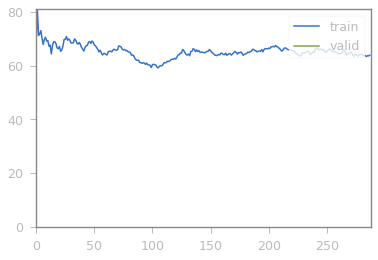

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 53 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5722


epoch,train_loss,valid_loss,accuracy,time
0,62.691528,62.971981,0.660839,01:34


Better model found at epoch 0 with accuracy value: 0.6608391404151917.


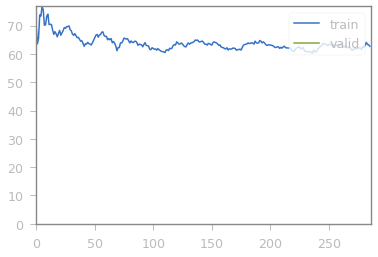

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,67.002258,62.367287,0.661597,01:47


Better model found at epoch 0 with accuracy value: 0.661596953868866.


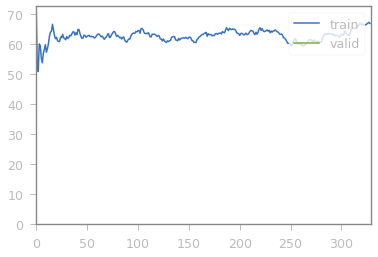

************Round:  0
TTA Accuracy:0.6687668561935425
cycle 2 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704), 30: (1.3199340032998386, 33.12331438064575)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6501


epoch,train_loss,valid_loss,accuracy,time
0,65.005707,60.385956,0.673846,01:46


Better model found at epoch 0 with accuracy value: 0.6738461256027222.


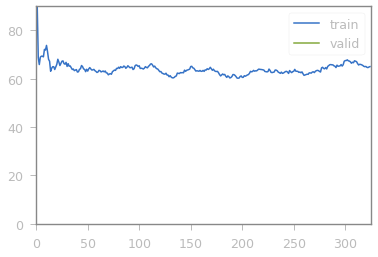

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 76 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6425


epoch,train_loss,valid_loss,accuracy,time
0,64.407654,58.750412,0.683268,01:44


Better model found at epoch 0 with accuracy value: 0.6832684874534607.


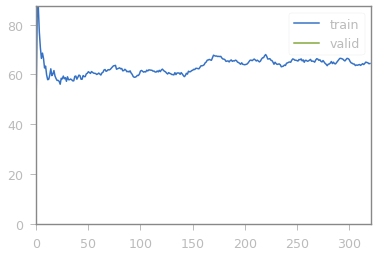

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 58 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6367


epoch,train_loss,valid_loss,accuracy,time
0,61.647282,61.261734,0.670071,01:44


Better model found at epoch 0 with accuracy value: 0.6700707077980042.


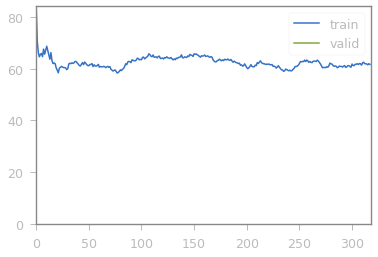

************Round:  3
TTA Accuracy:0.6705670356750488
cycle 2 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704), 30: (1.3199340032998386, 33.12331438064575), 33: (4.49977501124944, 32.94329643249512)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 63 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6304


epoch,train_loss,valid_loss,accuracy,time
0,63.913475,61.785065,0.664286,01:43


Better model found at epoch 0 with accuracy value: 0.6642857193946838.


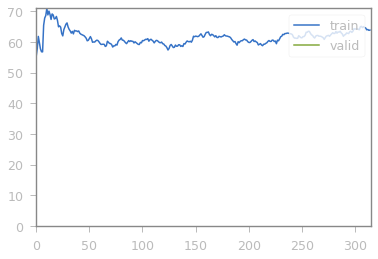

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 70 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6234


epoch,train_loss,valid_loss,accuracy,time
0,62.163109,57.682823,0.687801,01:41


Better model found at epoch 0 with accuracy value: 0.687800943851471.


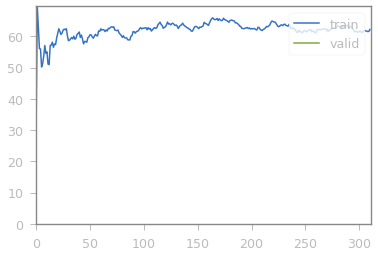

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 53 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6181


epoch,train_loss,valid_loss,accuracy,time
0,64.045441,59.027786,0.679612,01:41


Better model found at epoch 0 with accuracy value: 0.6796116232872009.


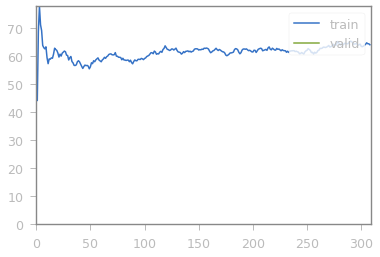

************Round:  6
TTA Accuracy:0.6717671751976013
cycle 2 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704), 30: (1.3199340032998386, 33.12331438064575), 33: (4.49977501124944, 32.94329643249512), 36: (7.289635518224092, 32.82328248023987)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 61 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6120


epoch,train_loss,valid_loss,accuracy,time
0,62.106140,54.268375,0.705882,01:40


Better model found at epoch 0 with accuracy value: 0.7058823704719543.


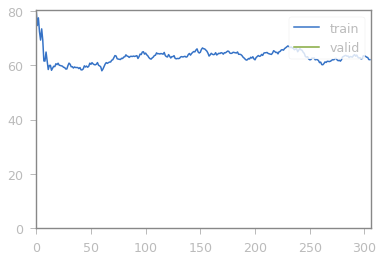

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 60 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6060


epoch,train_loss,valid_loss,accuracy,time
0,60.256916,58.726601,0.681518,01:39


Better model found at epoch 0 with accuracy value: 0.6815181374549866.


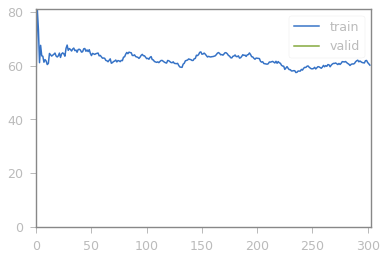

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 44
Min probability = 0.591044776119403
Dropped 53 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6007


epoch,train_loss,valid_loss,accuracy,time
0,63.461193,58.331696,0.684430,01:38


Better model found at epoch 0 with accuracy value: 0.6844296455383301.


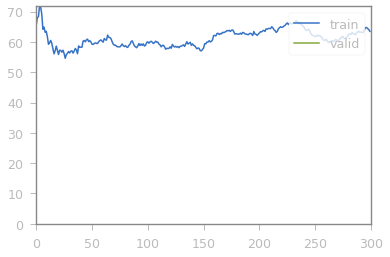

************Round:  9
TTA Accuracy:0.6696669459342957
cycle 2 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704), 30: (1.3199340032998386, 33.12331438064575), 33: (4.49977501124944, 32.94329643249512), 36: (7.289635518224092, 32.82328248023987), 39: (9.899505024748766, 33.033305406570435)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 43
Min probability = 0.5776119402985075
Dropped 52 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5955


epoch,train_loss,valid_loss,accuracy,time
0,61.787445,57.796947,0.686818,01:37


Better model found at epoch 0 with accuracy value: 0.6868178248405457.


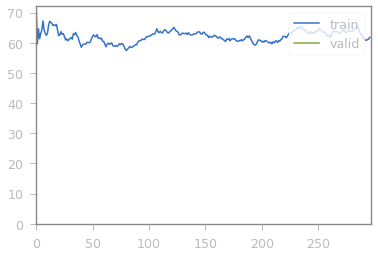

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 39
Min probability = 0.5238805970149254
Dropped 55 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5900


epoch,train_loss,valid_loss,accuracy,time
0,64.452995,62.434853,0.661864,01:36


Better model found at epoch 0 with accuracy value: 0.6618643999099731.


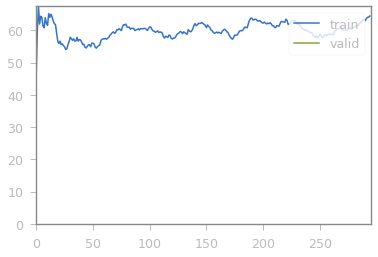

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 39
Min probability = 0.5238805970149254
Dropped 53 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5847


epoch,train_loss,valid_loss,accuracy,time
0,59.493275,58.864372,0.682635,01:36


Better model found at epoch 0 with accuracy value: 0.682634711265564.


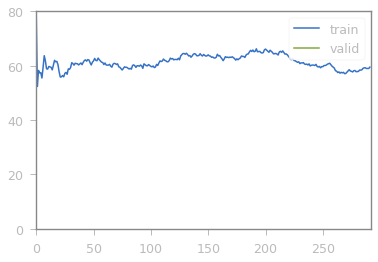

************Round:  12
TTA Accuracy:0.6684668660163879
cycle 2 Error Rate is [{0: (1.4099295035248205, 32.94329643249512), 3: (4.619769011549424, 33.663368225097656), 6: (7.39463026848658, 33.24332237243652), 9: (10.01949902504875, 33.30333232879639), 12: (12.28438578071096, 33.513349294662476), 15: (1.3199340032998386, 32.79327750205994), 18: (4.379781010949458, 33.153313398361206), 21: (7.334633268336588, 32.883286476135254), 24: (9.929503524823758, 32.79327750205994), 27: (12.479376031198441, 33.393341302871704), 30: (1.3199340032998386, 33.12331438064575), 33: (4.49977501124944, 32.94329643249512), 36: (7.289635518224092, 32.82328248023987), 39: (9.899505024748766, 33.033305406570435), 42: (12.299385030748466, 33.153313398361206)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 38
Min probability = 0.5104477611940298
Dropped 58 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5789


epoch,train_loss,valid_loss,accuracy,time
0,59.890797,60.256496,0.674157,01:35


Better model found at epoch 0 with accuracy value: 0.6741573214530945.


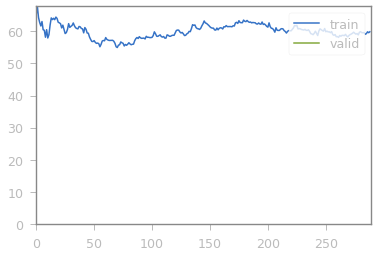

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 34
Min probability = 0.4567164179104478
Dropped 53 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5736


epoch,train_loss,valid_loss,accuracy,time
0,60.199245,61.321301,0.667829,01:34


Better model found at epoch 0 with accuracy value: 0.6678290963172913.


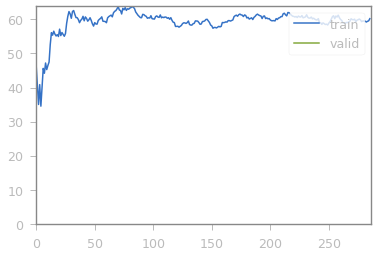

In [41]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedRCELossFlat(num_classes=num_classes,scale=20.0, delta = delta, reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

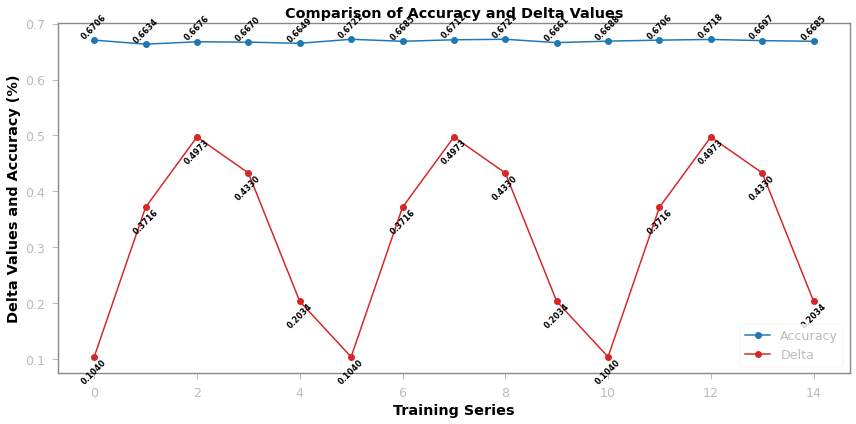

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
